# Age structured SIR model for the UK

We have used the excellent work performed by Rajesh Singh and R Adhikari to apply an SIR model using the Pyross module. Here, we want to see the prediction of this model using UK data, it is likely that this will be an exponential increase as is the case for India and other countries. Here we assume that there have been no interventions, we will conduct this work at a later stage.

We apply the model to the entire UK population and we obtain contact matrices provided from *Projecting social contact matrices in 152 countries using contact surveys and demographic data* by Prem et al. Note that we have obtained the infection paramter $\beta$ for the UK from private communications with Rajesh Singh. Please note that all credit goes to Rajesh Singh and R Adhikari, we have simply used their code to point towards the UK data and run simulations. More information around the technical details of their model, as well as their excellent paper, can be found here:

    - https://github.com/rajeshrinet/pyross
    - https://arxiv.org/abs/2003.12055

## Initial Config

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
## population and age classes
M=14  ## number of age classes

# load age structure data
my_data = np.genfromtxt('../data/age_structures/UK.csv', delimiter=',', skip_header=1)
aM, aF = my_data[:, 1], my_data[:, 2]

# set age groups
Ni=aM+aF;   Ni=Ni[0:M];  N=np.sum(Ni)

In [5]:
# contact matrices
my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_home_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CH = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_work_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CW = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_school_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CS = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_other_locations_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CO = np.array(my_data)

my_data = pd.read_excel('../data/contact_matrices_152_countries/MUestimates_all_locations_2.xlsx', sheet_name='United Kingdom of Great Britain',index_col=None)
CA = np.array(my_data)

# matrix of total contacts
C=CH+CW+CS+CO

## UK case data

In [6]:
import urllib.request, json

#GET JSON FILE
#Open the JSON file
with urllib.request.urlopen('https://opendata.ecdc.europa.eu/covid19/casedistribution/json/') as url:
    data = json.loads(url.read().decode('utf-8-sig'))

#Make a list of nested dictionaries
data = data['records']

#Put into dataframe
df = pd.DataFrame(data)

df['dateRep'] = pd.to_datetime(df['dateRep'], format='%d/%m/%Y')

#We will isolate a dataframe containing data only for the UK
df_uk = df.loc[df['countriesAndTerritories'] == 'United_Kingdom']

#We make a dataframe for the only the UK cases in order to complete analysis
df_cases_uk = df_uk[['dateRep', 'cases']]
df_cases_uk = df_cases_uk.astype({'cases': 'float64'})

df_cases_uk = df_cases_uk[(df_cases_uk['dateRep']>'2020-02-29')].sort_values(by='dateRep')

## Model

In [26]:
beta  = 0.02646691       # infection rate 
gIa   = 1./7             # recovery rate of asymptomatic infectives 
gIs   = 1./7             # recovery rate of symptomatic infectives 
alpha = 0.               # fraction of asymptomatic infectives 
fsa   = 1                # the self-isolation parameter   
    
    
# initial conditions    
Is_0 = np.zeros((M));  Is_0[6:13]=3;  Is_0[2:6]=1

Ia_0 = np.zeros((M))
R_0  = np.zeros((M))
S_0  = Ni - (Ia_0 + Is_0 + R_0)


# matrix for linearised dynamics
L0 = np.zeros((M, M))
L  = np.zeros((2*M, 2*M))

for i in range(M):
    for j in range(M):
        L0[i,j]=C[i,j]*Ni[i]/Ni[j]

L[0:M, 0:M]     =    alpha*beta/gIs*L0
L[0:M, M:2*M]   = fsa*alpha*beta/gIs*L0
L[M:2*M, 0:M]   =    ((1-alpha)*beta/gIs)*L0
L[M:2*M, M:2*M] = fsa*((1-alpha)*beta/gIs)*L0


r0 = np.max(np.linalg.eigvals(L))
print("The basic reproductive ratio for these parameters is", r0)

The basic reproductive ratio for these parameters is (2.030394689021418+0j)


In [27]:
# duration of simulation and data file
Tf=41;  Nf=2000;  

# the contact structure is independent of time 
def contactMatrix(t):
    return C

# intantiate model
parameters = {'alpha':alpha,'beta':beta, 'gIa':gIa,'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)


# run model
data=model.simulate(S_0, Ia_0, Is_0, contactMatrix, Tf, Nf)

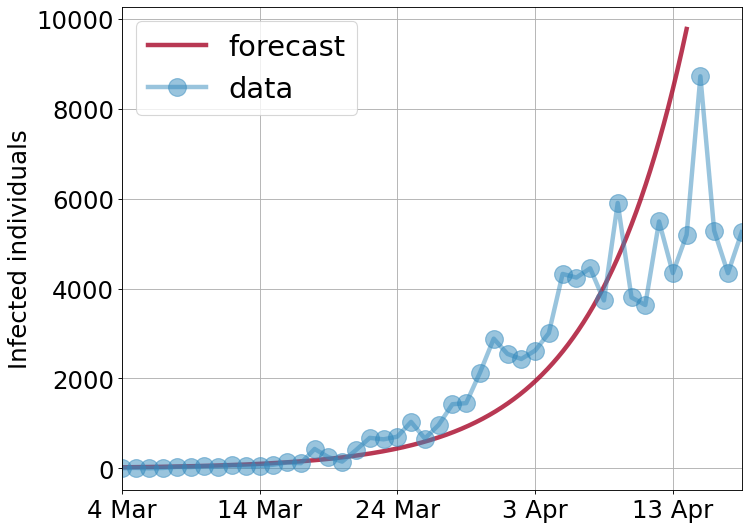

In [28]:
t = data['t']; IC  = np.zeros((Nf))
for i in range(M):
        IC += data['X'][:,2*M+i]
        

        
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.plot(t, IC, '-', lw=4, color='#A60628', label='forecast', alpha=0.8)
plt.xticks(np.arange(0, Tf, 10), ('4 Mar', '14 Mar', '24 Mar', '3 Apr', '13 Apr', '23 Apr'));

day, cases = df_cases_uk['dateRep'].to_numpy(), df_cases_uk['cases'].to_numpy()

plt.plot(cases, 'o-', lw=4, color='#348ABD', ms=16, label='data', alpha=0.5)

plt.legend(fontsize=26, loc='upper left'); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Infected individuals'); #plt.xlim(0, 40); plt.ylim(0, 9999);
#plt.savefig('/Users/rsingh/Desktop/2a.png', format='png', dpi=212)

Here we see that our initial prediction is valid as the number of infected individuals increases at an exponential rate. We also see that the model generally fits the number of cases. More work will need to be done to obtain a better fit but we think that this is a good starting point to make some informed decisions.